In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import dblquad


Starting from the following unconstrained model for the data
$$
    Y_i|\beta \sim \mathcal{N}(\int_{T} x_i(t)\beta(t) dt+ \mu, \sigma^2)
$$
$$
    \beta \sim GP(0,K)
$$

Assuming $\mu$ and $\sigma^2$ known, we consider functional coefficients $\beta^0$ equal to zero on a given set $T_0 ⊂ T$.  A random process $\beta^0=\beta^0(t)$ with such a property will be called a constrained random process. 

We can construct a **constrained Gaussian process  $\beta^0$** from the unconstrained
Gaussian process $\beta$ since, with probability one, $\beta$ can be decomposed into the sum of two independent Gaussian random processes $\beta^0$ and $\beta^1$ such that $\beta^0$ is zero on $T^0$. Nevertheless $\beta^0$ and $\beta^1$ share the same smoothness properties with $\beta$.

It can be shown that the distribution of $\beta^0$ can be viewed as the distribution of $\beta$ conditioned by $\beta_\tau=\beta(\tau) = 0$    $∀𝜏∈T_0$

Hence our Bayesian model is:
$$
    Y_i|\beta^0,\mu,\sigma^2 \sim N(\int_{T} \mu + x_i(t)*\beta^0(t) dt, \sigma^2)
$$
$$
    \beta^0|\sigma^2,T_0 \sim GP(0,\sigma^2 K^0)
$$
$$
    p(\mu,\sigma)\propto \frac{1}{\sigma^2}
$$


### Synthetic data generation

The intervals $T$ and $T_0$ are approximated using a finite grid of discrete values:
$$
        t_1,...t_g ∈ T   \text{  ,  }   \tau_1,...\tau_m ∈T_0
$$

While the integral is approximated using Rectangle rule.


In [2]:
sigma=0.5
mu=0
n=100
t00=-1
t01=1.5
t0=-3
t1=3
g=2**7
T = np.linspace(t0,t1,g)

#m???
step=(t1-t0)/(g-1)
i=t0
while np.abs(i)>np.abs(t00):
    i+=step
T0=np.arange(i, t01, step)
m=T0.size

Consider the RKHS with kernel $K(s, t) H$ and let's call 
- $H^0$ the subspace of functions that vanish in $T0$,  
- $H^1= (H^0)^ {\perp}$

Then any $g ∈ H^1$ can be approximated by a finite sum of the form $\quad g(t)\approx \sum_{\tau_i ∈ T_0}(a_i K(\tau_i,t))$

And for any $f ∈ H$ its approximated projection on $H^0$ is:
$$
        f^0(t)\approx f(t)-\sum_{\tau_i ∈ T_0}(a_i K(\tau_i,t))
$$


If we consider the finite grids of discrete values of $T^0$ and $T$ and we call:
- $f_t$ the column vector of values $[f_t]_i=f(t_i)  ,  \quad  t=(t_1,...t_g)∈T$
- $f_t$ the column vector of values $[f_\tau]_i=f(\tau_i)  ,  \quad  \tau=(\tau_1,...\tau_m)∈T_0$
- $K_{tt}$ the gxg matrix with entries $[K_{tt}]_{ij}=K(t_i,t_j)  ,  \quad  t=(t_1,...t_g)∈T$
- $K_{\tau \tau}$ the mxm matrix with entries $[K_{\tau \tau}]_{ij}=K(\tau_i,\tau_j)  , \quad    \tau=(\tau_1,...\tau_m)∈T_0$
- $K_{t \tau}$ the gxm matrix with entries $[K_{t \tau}]_{ij}=K(t_i,\tau_j)$
- $a$ the vector of $(a_1,...a_m)^{'}$


We can write: 
$$
    f^0_t= f_t-K_{\tau \tau}a
$$
and knowing that $f^0(\tau)=0 \quad ∀ \tau ∈T_0$, we get:
$$
    f^0_t= f_t-K_{t \tau}K_{\tau \tau}^{-1}f_{\tau}
$$




Here we start from $f(t)=sin(t \pi/4)$ and  then we approximate $\beta^0$ with $f^0(t)$:

$$ 
f(t)=sin(t \pi/4) \quad \text{ and }\quad f^0(t)=\beta^{0}_{true}(t)\approx\beta^{0}(t)
$$


In [3]:
def original_function(t): 
    return np.sin(t * np.pi / 4)

def gaussian_kernel(s, t):
    return np.exp(-2*(t - s)**2) 


Ktau=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        Ktau[i,j]=gaussian_kernel(T0[i],T0[j]) 
        
Kt_tau=np.zeros((g,m))
for i in range(g):
    for j in range(m):
        Kt_tau[i,j]=gaussian_kernel(T[i],T0[j])   
        
    
#rectangle for approx of integrals
def rect(t0,t1,f): 
    n_rect=30 
    h=(t1-t0)/n_rect
    summ=0
    for i in range(t0,t1):
        summ += f[np.abs(T - (i+h)/2).argmin()]
    return summ*h
    

beta0=np.zeros(g)
beta0=np.sin(T* np.pi / 4)-np.dot(Kt_tau,np.linalg.inv(Ktau+np.diag(np.full(m, 0.001)))).dot(np.sin(T0 * np.pi / 4))
    
# covariate generation
np.random.seed(2326)
K = np.zeros((g,g))
for i in range(g):
    for j in range(g):
        K[i,j]=gaussian_kernel(T[i],T[j])        
x = np.random.multivariate_normal(np.zeros(g),K,n)  
err=np.random.normal(mu,sigma,n)

y = np.zeros(n) 
for j in range(n): 
    y[j]=rect(t0,t1,x[j,:]*beta0[j])+err[j]



Text(0.5, 1.0, 'Beta0 (true)')

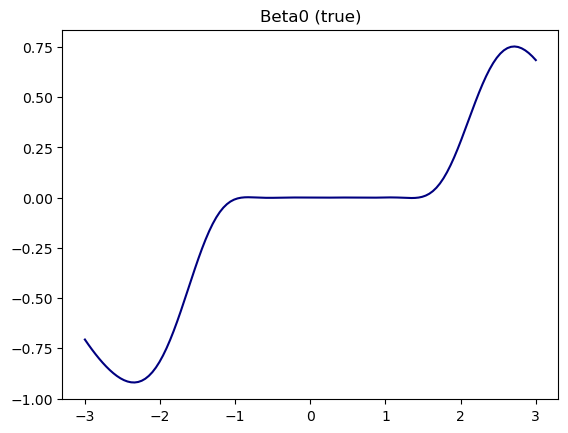

In [12]:
plt.plot(T,beta0,color='navy')
plt.title('Beta0 (true)')

### Posterior distribution


The posterior distribution of $\beta^0$ becomes:
$$
    \beta^0|\mu,\sigma^2,T_0 \sim GP(m,K^*)
$$

Where
$$
    m(t) = L^0x(t)^{'}M^{-1}(Y-\mu I_n)
$$
$$
    K^*(s,t) = \sigma^2(K^0(s,t) - L^0x(s)^{'}M^{-1}L^0x(t))
$$
with
$$
    L^0x(t)^{'} = [L^0x_1(t), ..., L^0x_n(t)]
$$
$$
  L^0x_i(t) = \int_{T} K^0(t,s)x_i(s)ds  
$$
$$
    M=\Sigma_0+I_n
$$
$$
    \Sigma^0_{ij} = R^0(x_i, x_j)= \int_{T} \int_{T} K^0(s,t)x_i(s)x_j(t)ds dt
$$

Integrals are approximated using finite sums:

* Projection $K^0$ of $K$ into the subspace $H^0$ of $H$ (RKHS with kernel K)

    We define the $gxg$ matrix $K^0_{tt}$ with entries $[K^0_{tt}]_{ij}=K^0(t_i,t_j)\quad t=(t_1,...t_g)∈T$  and approximate it as:


$$
     K^0_{tt}\approx K_{tt}-K_{t\tau}K{\tau \tau}^{-1} K_{t\tau}^{'}
$$

* Integral operator L with kernel $K^0$
  
$$   L^0x(t)^{'}\approx \delta K^0_{tt}X^{'}
$$

* Covariance matrix with kernel $K^0$
 
$$
    \Sigma^0\approx \delta^2 XK^0_{tt}X^{'}
$$
     Where
$$   \delta = t_{i+1} − t_{i}
$$
$$   X    \text{     nxg matrix with entries    }   [X]_{ij} = x_i(t_j)
$$


In [5]:
def gaussian_kernel(s, t):
    return np.exp(-2*(t - s)**2) 


Ktau=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        Ktau[i,j]=gaussian_kernel(T0[i],T0[j]) 
        
Kt_tau=np.zeros((g,m))
for i in range(g):
    for j in range(m):
        Kt_tau[i,j]=gaussian_kernel(T[i],T0[j])   
        
K0=np.zeros((g,g))     
K0=K-np.dot(np.dot(Kt_tau,np.linalg.inv(Ktau+np.diag(np.full(m, 0.001)))),np.transpose(Kt_tau))

#128*100
L0=np.transpose(step*np.dot(K0,np.transpose(x)) ) #should be 100*128     128*128 *  128*100= 128*100


S0=step**2*np.dot(np.dot(x,K0),np.transpose(x))

In [6]:
# Posterior Parameter:
M = np.zeros((n,n))
M=S0+np.identity(n)

mt=np.zeros(g)
mt=np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),(y-mu*np.ones(n))))
Kst = np.zeros((g,g))
Kst=sigma**2*(K0-np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),L0)))


The conditional density of $Y$ given $T_0$ is:
$$
    p(Y|T_0)\propto |M|^{1/2}S_{11}^{-1/2}b^{-(n-1)/2}
$$

where
$$
    b=0.5(S_{YY}-S_{1Y}^2/S_{11}) \text{  ,}  \quad S_{11}=\mathbf{1}_{n}^{'}M^{-1}\mathbf{1}_{n}\text{  ,} \quad  S_{1Y}=\mathbf{1}_{n}^{'}M^{-1}Y \text{  ,}  \quad S_{YY}=Y^{'}M^{-1}Y
$$
and
$$
        p(\mu, \sigma^2|Y,T_0)=NIG(S_{1Y}/S_{11}, 1/S_{11}, (n-1)/2, b)
$$

Hence, when $T_0$ is fixed at its posterior mode  $\hat{T^0}$ :
$$
     \hat{\beta^0}= \mathbf{E}(\beta_t^0|Y,T_0)=L^0x(t)^{'}M^{-1}(Y-S_{1Y}/S_{11}\mathbf{1}_n)
$$

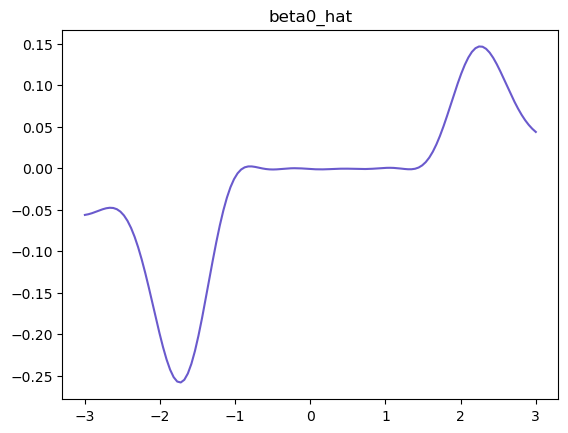

In [7]:
S11=np.ones(n).T@np.linalg.inv(M)@np.ones(n)
S1Y=np.ones(n).T@np.linalg.inv(M)@y
beta0_hat=np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),(y-np.zeros(n)*(S1Y/S11)))) #mu=0
plt.plot(T,beta0_hat,color='slateblue')
plt.title('beta0_hat')

T0_hat=T[list(np.where(np.abs(beta0_hat)<1e-2)[0])[3:]] #beta0_hat goes approximately to zero plus I discard the first three 
                                                        #values where the function is approx zero but not because of the constraint


## Simulate from the posterior

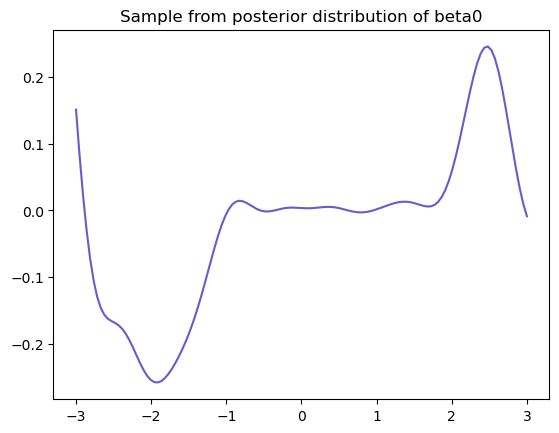

In [8]:
np.random.seed(2325)
beta_p = np.random.multivariate_normal(mt,Kst)
plt.plot(T,beta_p,color='slateblue')
plt.title('Sample from posterior distribution of beta0')
np.random.seed(2325)


In [9]:
#95% CI
beta_p_sample= np.random.multivariate_normal(mt,Kst,size=1000)  
intervals=np.percentile(beta_p_sample,[5,95],axis=0)


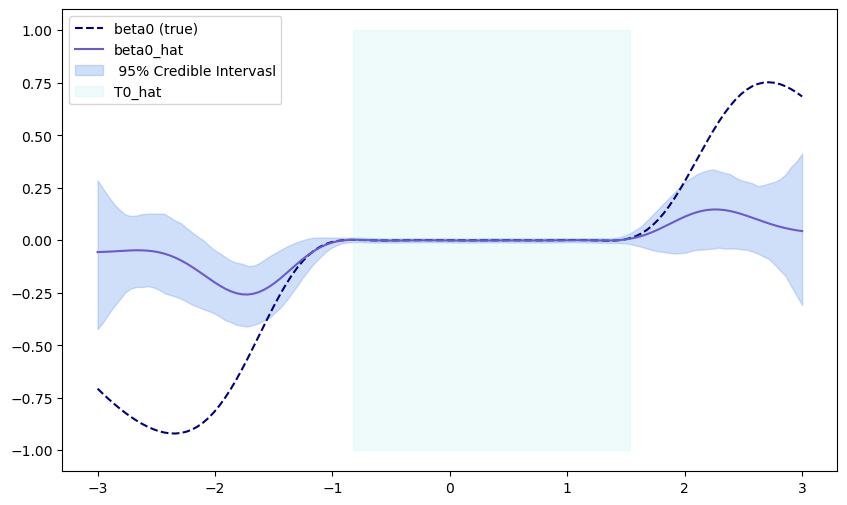

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(T,beta0,linestyle='dashed',color='navy',label='beta0 (true)')
plt.plot(T,beta0_hat, label='beta0_hat', color='slateblue')
plt.fill_between(T, intervals[0, :],intervals[1, :], alpha=0.3, label=' 95% Credible Intervasl', color='cornflowerblue')
plt.fill_betweenx(y=[-1, 1], x1 = T0_hat[0], x2 = T0_hat[-1],alpha=0.2,label='T0_hat',color='paleturquoise')  # You can adjust this value
plt.legend()
plt.show()

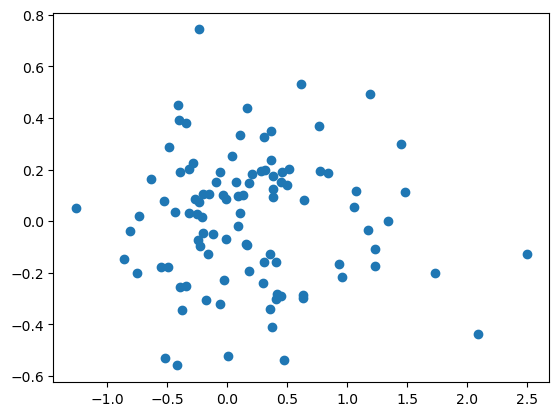

In [11]:
# Predict Y_i from the beta_p
y_pred = np.zeros(n) # np.random.multivariate_normal(np.zeros(n),S + sigma * np.identity(n))
err1=np.random.normal(mu,sigma,n)
for i in np.arange(0,n):
    y_pred[i] = mu + rect(t0,t1,x[i,:]*beta_p) + sigma *err1[i]

# Comparison with the true Y_i
plt.scatter(y,y_pred)